# imports

In [1]:
import astropy as ap
from stingray import Lightcurve, CrossCorrelation

In [2]:
%run read_matlab_file.ipynb
%run LC_calibration.ipynb

all UiB paths loaded
read_matlab_file.ipynb loaded successfully!
all UiB paths loaded
read_matlab_file.ipynb loaded successfully!
all UiB paths loaded
read_matlab_file.ipynb loaded successfully!
convert_erg.ipynb loaded successfully!
all UiB paths loaded
read_matlab_file.ipynb loaded successfully!
all UiB paths loaded
read_matlab_file.ipynb loaded successfully!
convert_erg.ipynb loaded successfully!
safety_time.ipynb loaded successfully!
LC_calibration loaded successfully!


# XPEC data preperation

### TODO
    - Extract the bins from the txt file. DONE
    
    - Bin the keV into the predefined bins. DONE
    
    - Implement function for T0 & tus correction (ToF). DONE
        --> COMMENT: still 300ms error after calibrating GRB190206
        
    -Do all the steps above for GRB200415A and cross check results. DONE
    
    - Implement function for cutting the tus & keV array at time interval given by Anastasia or GCN report 
        ---> NEXT UP
 
    - make sure the T0 are correctly clibrated. Send complete list to Andrey for validation
    
    
### Notes
    -Assuming 
    -bins_keV are the right most edges! 
    -Anders have filtered for keV >=500 
    -Implementation is ok. Proceed to wrapping a function around it.
    --> have a shift variable as input (have to do with lining up the LC from the different spacecrafts)
    
    
### Problems
    -GRB200415: Problem lining up the T0 from my data to the data that Anders used to histogram the data for 0.8ms <=tus <= 3.2ms
    Since the data is shifted a small amount the number of counts in the bins don't match up correctly.
    --> Absolute time correction is neccecary, but this value might be different from the one Anders used.
    -->Error of 4151.099 ... us (4.1 ms) from df_A and my df.
 
    
    -GRB200415: The binning does not produce the same bin counts in Ander´s df_A and the df_check
    --> Because of filtering for keV's >= 500
    
    

In [3]:
#time of flight from KW to ASIM. Given in seconds
ToF = {"GRB180720":-4.2377,"GRB181222":2.8716, "GRB190206":4.9225, "GRB190305":3.4460,
      "GRB190606":4.0316,"GRB200415":4.1840,"GRB200521":-0.6226,"GRB200716":3.0155,
      "GRB201227":0.7142, "GRB210424":-0.5033, "GRB210619":-2.6183}

In [4]:
def ToF_correction(grb_id=None):
    ToF_us = ToF[grb_id]*1e6
    df,T0 = complete_df(grb_id=grb_id)
    df["tus"], T0_calibrated = df["tus"] - ToF_us, T0 - timedelta(microseconds=ToF_us) #calibrating 
    return df,T0,T0_calibrated

# bin control

In [5]:
df_bin = pd.read_csv(bin_edges_path + "HED_binedges.txt")
df_bin.head()

,energy_bin_start_keV,energy_bin_stop_keV
0,10.00000,12.58925
1,12.58925,15.84893
2,15.84893,19.95262
3,19.95262,25.11886
4,25.11886,31.62278


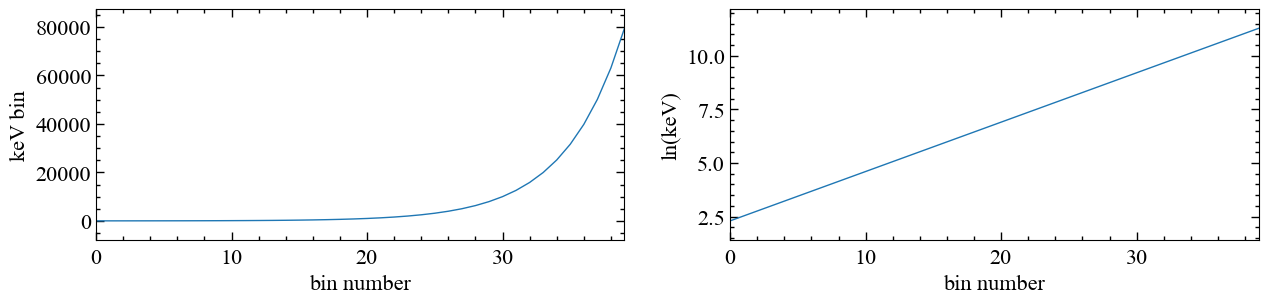

In [6]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,3))

ax1.plot((df_bin["energy_bin_start_keV"]))
ax2.plot(np.log(df_bin["energy_bin_start_keV"]))
ax1.set_xlabel("bin number")
ax1.set_ylabel("keV bin")
ax2.set_xlabel("bin number")
ax2.set_ylabel("ln(keV)")
plt.show()

In [7]:
start = df_bin["energy_bin_start_keV"].to_numpy()
#start = np.append(0,start)
end = df_bin["energy_bin_stop_keV"].to_numpy()
bins_keV=np.append(start,end[-1])
print(len(bins_keV))
bins_keV

41


array([1.000000e+01, 1.258925e+01, 1.584893e+01, 1.995262e+01,
       2.511886e+01, 3.162278e+01, 3.981072e+01, 5.011872e+01,
       6.309573e+01, 7.943282e+01, 1.000000e+02, 1.258925e+02,
       1.584893e+02, 1.995262e+02, 2.511886e+02, 3.162278e+02,
       3.981072e+02, 5.011872e+02, 6.309573e+02, 7.943282e+02,
       1.000000e+03, 1.258925e+03, 1.584893e+03, 1.995262e+03,
       2.511886e+03, 3.162278e+03, 3.981072e+03, 5.011872e+03,
       6.309573e+03, 7.943282e+03, 1.000000e+04, 1.258925e+04,
       1.584893e+04, 1.995262e+04, 2.511886e+04, 3.162278e+04,
       3.981072e+04, 5.011872e+04, 6.309573e+04, 7.943282e+04,
       1.000000e+05])

In [8]:
df_hist_check = pd.read_csv(bin_edges_path + "HED_(0.8 ms to 3.2 ms).txt")
print("Num hist counts totoal: ", sum(df_hist_check["counts"].to_numpy()[1:]))
print("bins_keV are the right most edge")

df_hist_check.tail()

Num hist counts totoal:  300.0
bins_keV are the right most edge


,bins_keV,counts,poisson_error_counts,duration_seconds
36,39810.72,1.0,1.0,0.0024
37,50118.72,0.0,0.0,0.0024
38,63095.73,0.0,0.0,0.0024
39,79432.82,0.0,0.0,0.0024
40,100000.00,0.0,0.0,0.0024


# keV bin function

In [10]:
def keV_hist(df=None,t_start=None,time_interval=None,duration=None,keV_interval=None,keV_bins=None):
    '''
    NOTE: working with ms resolution for the tus array
    
    input: df <pd.dataframe> complete dataframe with no flagged events
    time_interval <tuple> start and end (ms) of the time interval for the keV binning.
    keV_interval <tuple> default is None. Meaning the whole spectrum
    duration <float> defaul is None. Must be provided in ms 
    
    return: <pd.dataframe> with the bin_counts and bin_edges as a dataframe
    '''
    df.sort_values(by=['tus'],inplace=True) #first sorting by tus in increasing order
    
    
    #tus handling-------------------------------------------
    tus_arr = df["tus"].to_numpy()
    tus_arr = tus_arr/1e3 #converting to ms resolution

    
    #if t_start==None:
    #    tus_start,tus_end = min(tus_arr),max(tus_arr)
    #    idx_start, idx_end = find_nearest(tus_arr,tus_start), find_nearest(tus_arr,tus_end)+1 #including the last trigger
    if time_interval != None:
        idx_start, idx_end = find_nearest(tus_arr,time_interval[0]), find_nearest(tus_arr,time_interval[1])+1
    else:
        if duration==None:
            return print("duration must be specified in ms")
        else:
            tus_start,tus_end = t_start,t_start+duration #selecting the interval
            idx_start, idx_end = find_nearest(tus_arr,tus_start), find_nearest(tus_arr,tus_end)+1 #including the nearest trigger
    

    tus_arr = tus_arr[idx_start:idx_end] #selecting the interval for tus
    
    #keV handling-------------------------------------------
    keV_arr = df["keV"].to_numpy()
    keV_arr = keV_arr[idx_start:idx_end] #selecting keV's on the given tus interval
    
    if keV_interval==None:
         keV_lower,keV_upper = 0,1e5 #selecting artificially high bounds
    else: 
        keV_lower,keV_upper = keV_interval[0],keV_interval[1] #selecting the bounds for the keV's

    ii = []
    for i,keV in enumerate(keV_arr): #finding
        if keV_lower<=keV<=keV_upper:
            ii.append(i)
            
    tus_keV_bound = tus_arr[ii]
    keV_bound = keV_arr[ii]
    
    #histogramming-----------------------------------------
    hist_keV,edges_keV = np.histogram(keV_bound,bins=keV_bins)
    
    poisson_arr = np.sqrt(hist_keV) #handle this one. might be some negative numbers in it?
    if hist_keV[0] == 0:
        hist_keV = np.append(-9999.0,hist_keV)
        poisson_arr = np.append(-9999.0,poisson_arr)
    duration_arr = np.append(-9999.0,(([duration/1e3])*(len(hist_keV)-1)))
    df_keV = pd.DataFrame({"bins_keV":edges_keV, "counts":hist_keV, 
                           "poisson_error_counts":poisson_arr, "duration_seconds":duration_arr}) #ERROR different lengths!
    print("Energies binned!")
    return df_keV

# Exporting all keV histograms

In [ ]:
df,T0 = complete_df(grb_id="GRB190206",remove_flag=True)

tus = df["tus"].to_numpy()
start,end = find_nearest(tus/1e3,297),find_nearest(tus/1e3,361)

In [ ]:
start_bg,end_bg = find_nearest(tus/1e3,-500),find_nearest(tus/1e3,200)
start_bg,end_bg

In [ ]:
pd.set_option('display.float_format', '{:.6E}'.format)

In [ ]:
df_keV = keV_hist(df=df,time_interval=(297.0,361.0),keV_bins=bins_keV,duration=64.0)

In [ ]:
df_keV_bg = keV_hist(df=df,time_interval=(-600.0,200.0),keV_bins=bins_keV,duration=64.0)

np.savetxt(r'/Users/andreas/phys/master/GRB/spectral_analysis/GRB190206A_keV_histogram.txt"',df_keV.values, delimiter=',', 
           header='bins_keV,counts,poisson_error_counts,duration_seconds', fmt='%.6E')

np.savetxt(r'/Users/andreas/phys/master/GRB/spectral_analysis/GRB190206A_keV_hist_background (-600 ms to 200 ms).txt"',df_keV_bg.values, delimiter=',', 
           header='bins_keV,counts,poisson_error_counts,duration_seconds', fmt='%.6E')

## bring KW data into ASIM referance frame with ToF and time lagg=27 ms

### TODO: 
    -Round cal_abc to .7 position
    -Subtract/add ToF from the bins
    -subtract/add time lagg to kw data
    -plot the histograms together for the selected time interval

    -Prepare the new data file for GRB201227


In [11]:
kw_grb190206_2ms = kw_lc_path + "GRB190206A_2ms.txt"
kw_df = pd.read_csv(kw_grb190206_2ms,sep='\s+')

G1,G2,G3 = kw_df["G1"], kw_df["G2"], kw_df["G3"]

kw_bin_left = kw_df["Ti"].to_numpy()#+ToF["GRB190206"]
kw_bin_right = kw_df["Tf"].to_numpy()#+ToF["GRB190206"]

kw_bin_left = np.append(kw_bin_left,kw_bin_right[-1])


kw_start = find_nearest(kw_bin_left,0)
kw_end = find_nearest(kw_bin_left,0)+ int(64/2) #64ms interval

kw_bin_left = kw_bin_left[kw_start:kw_end]
G1,G2,G3 = G1[kw_start:kw_end],G2[kw_start:kw_end],G3[kw_start:kw_end]


binwidth=np.append(np.round(np.diff(kw_bin_left),3),0.002) #binwidths differentiated and rounded. Added the last bin width
len(G1),len(kw_bin_left),len(binwidth)

(32, 32, 32)

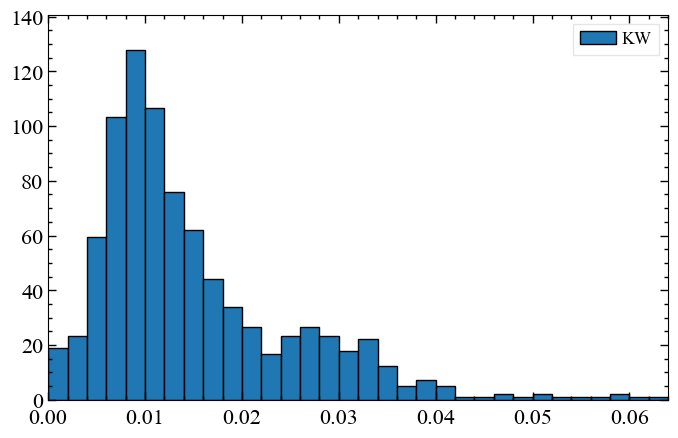

In [12]:
plt.bar(x=kw_bin_left,height=G3,width=binwidth,align="edge",edgecolor="black",label="KW")
plt.legend()
plt.show()

### ASIM

In [ ]:
df,T0 = complete_df(grb_id="GRB190206",remove_flag=True)
df.sort_values(by=['tus'],inplace=True)
tus = df["tus"].to_numpy()
tus = tus/1e3
opt_cut_asim = 293
A_start,A_end = find_nearest(tus,opt_cut_asim),find_nearest(tus,opt_cut_asim+64)
tus_cut = tus[A_start:A_end]
print(T0)
A_hist,A_edges = np.histogram(tus_cut,bins=np.arange(min(tus_cut), max(tus_cut) + 2, 2))

In [ ]:
plt.bar(x=np.arange(0,len(kw_bin_left)),height=(G3+G2),width=1,align="edge",edgecolor="black",label="KW G3 + G2",alpha=0.7)
#plt.bar(x=np.arange(0,len(kw_bin_left)),height=G2,width=1,align="edge",edgecolor="black",label="KW G2",alpha=0.3)
#plt.bar(x=np.arange(0,len(kw_bin_left)),height=G1,width=1,align="edge",edgecolor="black",label="KW G1",alpha=0.2)

plt.bar(x=np.arange(0,len(A_edges)-1), height=A_hist,width=1,align="edge",edgecolor="black",label="ASIM",alpha=0.5)
plt.xlabel("bin number [64 ms window, 2ms bins]")
plt.ylabel("counts/ 2ms")
plt.legend()
plt.title("KW plotted from T0_KW and ASIM plotted from T0_ASIM + {}ms".format(opt_cut_asim))
plt.show()

In [ ]:
df,T0 = complete_df(grb_id="GRB190206",remove_flag=True)
df.head()

In [ ]:
df,T0 = complete_df(grb_id="GRB190206",remove_flag=True)

df.sort_values(by=['tus'],inplace=True)
tus = df["tus"].to_numpy()
plot_HED(tus_arr=tus,binsize=2,T0=T0)

In [ ]:
T0_KW = "03:49:23.926"
T0_KW_dt = datetime.strptime(T0_KW,"%H:%M:%S.%f")
T0_KW_dt + timedelta(seconds=ToF["GRB190206"])
T0_KW_dt

In [ ]:
# export keV histogram for GRB190206A in the same format as example by Anders, Duration is 64 ms 
# lag = -27.


#build spectra for main event on this interval
time_interval = 297,297+64 #ms


#interval for background:
bg_interval = -0.9,-0.2


In [ ]:
#for grb_id in selected_grb_id:
#    df,T0 = complete_df(grb_id=grb_id,remove_flag=True,flag_cut="HED")
#    df_keV = keV_hist(df=df,keV_bins=bins_keV)
#    print("Exporting csv")
#    df_keV.to_csv(path_keV_hist + grb_id,index=False)

In [ ]:
#bins_keV


from astropy.table import Table
df = pd.read_csv("/Users/andreas/phys/master/GRB/spectral_analysis/keV_histograms/GRB180720")
t = Table.from_pandas(df)
t.write('GRB180720_new.fits')

# GRB201227

In [ ]:
plot_HED(grb_id="GRB201227",binsize=4)

## TODO
    -This GRB also have FERMI GBM data. Learn how to import that data
    -CUT TIME FOR ASIM: T0 + 534ms
    -Generate a new txt file with the same parameter columns as GRB190206
    

## ASIM import and preparation

In [ ]:
df_GRB201227, T0_GRB201227 = complete_df(grb_id="GRB201227",remove_flag=True)
print(T0_GRB201227)
df_GRB201227.sort_values(by=["tus"],inplace=True)
df_GRB201227.head()


In [ ]:
# TODO: wrap this into a function for calculating the time lag between ASIM and KW 


tus_GRB201227 = df_GRB201227["tus"].to_numpy()
tus_GRB201227 = tus_GRB201227/1e3 - cc  #working in ms
tus_GRB201227 = tus_GRB201227/1e3 #working in seconds

#assuming KW spectra is build from T0_KW --> that will be around T0_ASIM + 525ms ish
#assuming 64ms window aswell

opt_cut_GRB201227 = -0.1
start_GRB201227 = find_nearest(tus_GRB201227,opt_cut_GRB201227)
end_GRB201227 = find_nearest(tus_GRB201227,opt_cut_GRB201227+0.2)
hist_GRB201227, edges_GRB201227 = np.histogram(tus_GRB201227[start_GRB201227:end_GRB201227],
                                               bins=np.arange(min(tus_GRB201227[start_GRB201227:end_GRB201227]),max(tus_GRB201227[start_GRB201227:end_GRB201227])+0.002,0.002))
width_GRB201227 = np.round(np.diff(edges_GRB201227),3)
#print(len(hist_GRB201227),len(edges_GRB201227),len(width_GRB201227))

kw_GRB201227_2m = kw_lc_path + "GRB201227A_2ms.txt"
kw_GRB201227_df = pd.read_csv(kw_GRB201227_2m,sep='\s+')

G1,G2,G3 = kw_GRB201227_df["G1"].to_numpy(), kw_GRB201227_df["G2"].to_numpy(), kw_GRB201227_df["G3"].to_numpy()

kw_bin_left = kw_GRB201227_df["Ti"].to_numpy()#+ToF["GRB190206"]
kw_bin_right = kw_GRB201227_df["Tf"].to_numpy()#+ToF["GRB190206"]

kw_bins = np.append(kw_bin_left,kw_bin_right[-1])

kw_start =find_nearest(kw_bins,-0.1)
kw_end = find_nearest(kw_bins,0.1)

kw_use_bins = kw_bin_left[kw_start:kw_end]
G1,G2,G3 = G1[kw_start:kw_end],G2[kw_start:kw_end],G3[kw_start:kw_end]
kw_bin_width = np.append(np.round(np.diff(kw_use_bins),3),0.002)

#print(np.all(np.round(np.diff(kw_use_bins),3) ==0.002)) #binwidths differentiated and rounded. Added the last bin width
#print(len(G1),len(kw_use_bins),len(kw_bin_width))

In [ ]:
cc = 534

In [ ]:
from dateutil import parser
str_t0KW = '2020-12-27T15:14:06.705'
str_t0ASIM = '2020-12-27T15:14:06.853'
T0KW = parser.parse(str_t0KW) 
T0ASIM = parser.parse(str_t0ASIM)


In [ ]:
T0ASIM - timedelta(seconds=ToF["GRB201227"])

In [ ]:
lc1 = Lightcurve(time=kw_use_bins,counts=G3/max(G3),skip_checks=True)
lc2 = Lightcurve(time=edges_GRB201227[:-1],counts=hist_GRB201227/max(hist_GRB201227),skip_checks=True)

In [ ]:
lc1.plot()
lc2.plot()

In [ ]:
CC = CrossCorrelation(lc1=lc1,lc2=lc2,mode="full")
CC.plot()

In [ ]:
round(CC.cal_timeshift(dt=2)[0],3)*1e3 #ms because i initially cut it as 500 ms

## Extracting the data for GRB201227

In [ ]:
df_GRB201227.head()

In [ ]:
df_keV_GRB201227 = keV_hist(df=df_GRB201227,t_start=534,duration=64,keV_bins=bins_keV)

In [ ]:
df_keV_GRB201227_bg = keV_hist(df=df_GRB201227,time_interval=(-150,475),duration=625,keV_bins=bins_keV)

In [ ]:
pd.set_option('display.float_format', '{:.6E}'.format)

In [ ]:
df_keV_GRB201227_bg

np.savetxt(r'/Users/andreas/phys/master/GRB/spectral_analysis/GRB201227A_keV_histogram.txt',df_keV_GRB201227.values, delimiter=',', 
           header='bins_keV,counts,poisson_error_counts,duration_seconds', fmt='%.6E')